# Proposed Attention-CNN Model
Used for paper "A Biologically Inspired Attention-guided Machine Learning Approach for Pneumonia Diagnosis"

## 1. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0


2021-09-25 00:48:31.958114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 00:48:31.964524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 00:48:31.964928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 2. Data

### 2.1. Loading dataset

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [5]:
# # If you have not read data before, uncomment and run.
# def get_training_data(data_dir):
#     data = []
#     for dataset in ['train', 'test', 'val']:
#         dataset_dir = os.path.join(data_dir, dataset)
#         for label in labels: 
#             path = os.path.join(dataset_dir, label)
#             class_num = labels.index(label)
#             print(f'Currently reading: {path}')
#             for img in os.listdir(path):
#                 if (img == '.DS_Store'):
#                     continue
#                 try:
#                     img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                     resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
#                     data.append([resized_arr, class_num])
#                 except Exception as e:
#                     print(f'Error with {img}: {e}')
#     return np.array(data, dtype=object)

# data = get_training_data('/hdd/Pioneer/chest-xray-pneumonia/chest_xray/chest_xray/')
# np.save('data.npy', data, allow_pickle=True)

In [6]:
# If you've already ran the previous code block, run this one instead.
data = np.load('data.npy', allow_pickle=True)

In [7]:
# Shuffle dataset
np.random.seed(1337)
np.random.shuffle(data)

In [8]:
train, val, test = np.split(data, [int(.75*len(data)), int(.80*len(data))])

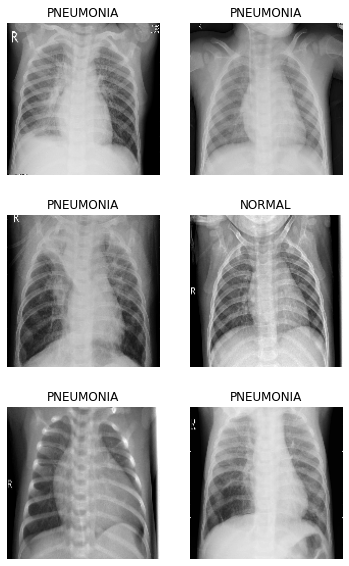

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(6,10), facecolor='white')
for idx, item in enumerate(np.random.randint(0, train.shape[0], 6)):
    ax[int(idx/2)][idx%2].imshow(train[item][0], cmap='gray')
    ax[int(idx/2)][idx%2].set_title(labels[train[item][1]])
    ax[int(idx/2)][idx%2].axis('off')

In [10]:
print(data.shape)
print(train.shape, val.shape, test.shape)

(5856, 2)
(4392, 2) (292, 2) (1172, 2)


In [11]:
# Train set splits
unique, counts = np.unique(train[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 3191]
 [1 1201]]


In [12]:
# Test set splits
unique, counts = np.unique(test[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 856]
 [1 316]]


In [13]:
# Validation set splits
unique, counts = np.unique(val[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 226]
 [1 66]]


In [14]:
unique, counts = np.unique(data[:, 1], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0 4273]
 [1 1583]]


In [15]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

<AxesSubplot:ylabel='count'>

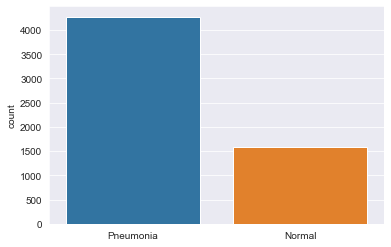

In [16]:
l = []
for i in data:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

### 2.2. Preprocessing

In [17]:
# Normalize data. Pixels are [0, 255], so dividing will place them into a [0, 1] range.
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [18]:
# Resize all images into a common size of 150 x 150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [19]:
print(x_train[0].shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(150, 150, 1) (4392, 150, 150, 1) (4392,) (292, 150, 150, 1) (292,) (1172, 150, 150, 1) (1172,)


In [20]:
# Data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## 3. Model

### 3.1. CBAM

In [21]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = self.shared_layer_one(max_pool)
            max_pool = self.shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [22]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

### 3.2. Model Architecture

In [23]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
    model.add(BatchNormalization())
    model.add(ChannelAttention(32, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(ChannelAttention(64, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(ChannelAttention(64, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(ChannelAttention(128, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(ChannelAttention(256, 8))
    model.add(SpatialAttention(3))
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    
    return model

### 3.3. Model Training

In [24]:
n_epoch = 50
lr = 0.001
batchsz = 16


METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc', curve='ROC'), # roc curve
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2021-09-24 23:33:22.784361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-24 23:33:22.784995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 23:33:22.785511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 23:33:22.785930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [25]:
optim = tf.keras.optimizers.Adam(learning_rate=lr)
model = create_model()
model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = METRICS)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=2, verbose=1, factor=0.8
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batchsz), 
    epochs = n_epoch, 
    validation_data = datagen.flow(x_val, y_val),
    callbacks = [learning_rate_reduction]
)

2021-09-24 23:33:23.387295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-09-24 23:33:24.955284: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


275/275 [==============================] - 9s 22ms/step - loss: 0.3050 - tp: 936.0000 - fp: 286.0000 - tn: 2905.0000 - fn: 265.0000 - accuracy: 0.8745 - precision: 0.7660 - recall: 0.7794 - roc: 0.9268 - prc: 0.7977 - val_loss: 1.1978 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 226.0000 - val_fn: 66.0000 - val_accuracy: 0.7740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc: 0.4327 - val_prc: 0.1958
Epoch 2/50
275/275 [==============================] - 5s 18ms/step - loss: 0.2386 - tp: 986.0000 - fp: 209.0000 - tn: 2982.0000 - fn: 215.0000 - accuracy: 0.9035 - precision: 0.8251 - recall: 0.8210 - roc: 0.9555 - prc: 0.8801 - val_loss: 0.3028 - val_tp: 33.0000 - val_fp: 3.0000 - val_tn: 223.0000 - val_fn: 33.0000 - val_accuracy: 0.8767 - val_precision: 0.9167 - val_recall: 0.5000 - val_roc: 0.9549 - val_prc: 0.8829
Epoch 3/50
275/275 [==============================] - 5s 19ms/step - loss: 0.2258 - tp: 995.0000 - fp: 175.0000 - tn: 3016.0000 - fn: 206.0000 - accurac

In [34]:
results = model.evaluate(x_test,y_test)

37/37 [==============================] - 0s 9ms/step - loss: 0.1205 - tp: 308.0000 - fp: 45.0000 - tn: 811.0000 - fn: 8.0000 - accuracy: 0.9548 - precision: 0.8725 - recall: 0.9747 - roc: 0.9936 - prc: 0.9845


In [35]:
print("Loss of the model is - " , results[0])
print("True positives of the model is - " , results[1])
print("False positives of the model is - " , results[2])
print("True negatives of the model is - " , results[3])
print("False negatives of the model is - " , results[4])
print("Accuracy of the model is - " , results[5]*100 , "%")
print("Precision of the model is - " , results[6])
print("Recall of the model is - " , results[7])
print("ROC_AUC of the model is - " , results[8])
print("PRC_AUC of the model is - " , results[9])

Loss of the model is -  0.12052619457244873
True positives of the model is -  308.0
False positives of the model is -  45.0
True negatives of the model is -  811.0
False negatives of the model is -  8.0
Accuracy of the model is -  95.47781348228455 %
Precision of the model is -  0.8725212216377258
Recall of the model is -  0.9746835231781006
ROC_AUC of the model is -  0.9936264753341675
PRC_AUC of the model is -  0.9844799637794495


In [29]:
model.save('../saved_models/my_model')

2021-09-24 23:37:56.565698: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../saved_models/my_model/assets


## 4. Results

### 4.1. Metrics plot

In [30]:
def plot_metrics(history):
    
    fig = plt.gcf()
    fig.set_size_inches(20, 3 * 4)

    metrics = ['roc','accuracy','loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        lims = {'loss': {0,2}}
        name = metric.replace("_"," ").capitalize()
        sp = plt.subplot(2, 3, n + 1)
        plt.plot(history.epoch, history.history[metric], color='C0', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='C1', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric in lims:
            plt.ylim(lims[metric])

        plt.legend()

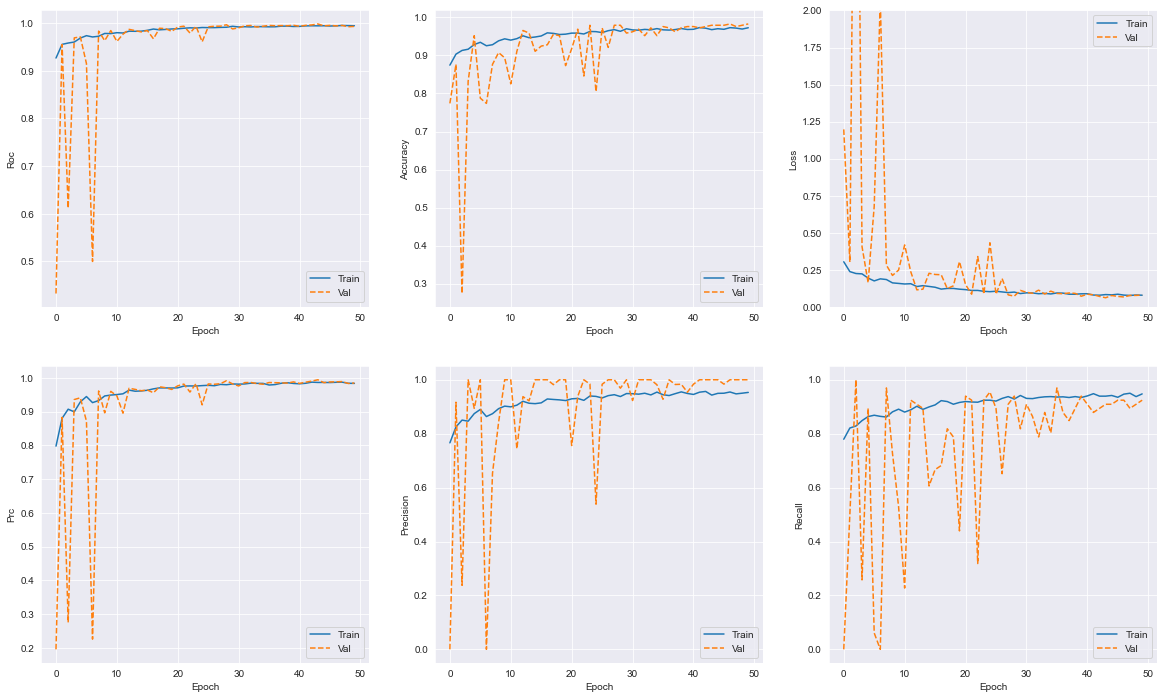

In [31]:
plot_metrics(history)

### 3.2. Classification Metrics

In [21]:
model = tf.keras.models.load_model('../saved_models/my_model')

2021-09-25 00:48:42.706735: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-25 00:48:42.707398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 00:48:42.707805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 00:48:42.708156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

2021-09-25 00:48:44.059904: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-25 00:48:44.511074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.95      0.97       856
   Normal (Class 1)       0.87      0.97      0.92       316

           accuracy                           0.95      1172
          macro avg       0.93      0.96      0.94      1172
       weighted avg       0.96      0.95      0.96      1172



In [23]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions)

0.9207772795216741

Text(70.0, 0.5, 'true label')

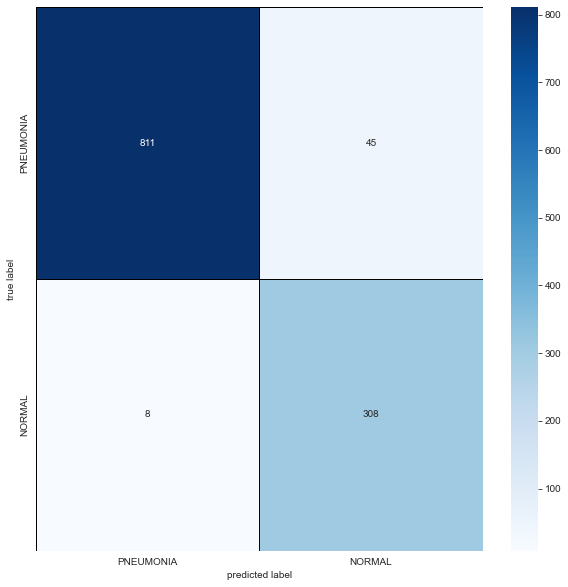

In [24]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.xlabel('predicted label')
plt.ylabel('true label')